In [3]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm
import torch
import torch.nn as nn

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, MiniBatchSparsePCA
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings('ignore')

from collections import Counter

cwd = os.getcwd()
cwd

'C:\\Users\\LSB\\Desktop\\넥토리얼_분석가과제'

# Step 0. Preprocessing
## 0-1. Read datasets

In [4]:
#data_dir = os.path.join(cwd, 'UX선행기획팀')
data_dir = cwd

output = pd.read_csv(os.path.join(data_dir, 'output_sample.csv'))

## Read game datasets
game_A = pd.read_csv(os.path.join(data_dir, 'game_A.csv'))
game_B = pd.read_csv(os.path.join(data_dir, 'game_B.csv'))
game_C = pd.read_csv(os.path.join(data_dir, 'game_C.csv'))

print("data size")
print('game_A', game_A.shape)
print('game_B', game_B.shape)
print('game_C', game_C.shape)


## Create id list
user_A = set(game_A['id'])
user_B = set(game_B['id'])
user_C = set(game_C['id'])

user_AnB = set(game_A['id']) & set(game_B['id'])
user_AnC = set(game_A['id']) & set(game_C['id'])

print("No. of game A user:", len(user_A))
print("No. of game B user:", len(user_B))
print("No. of game C user:", len(user_C))
print("\nNo. of game A and B user:", len(user_AnB))
print("No. of game A and C user:", len(user_AnC))

data size
game_A (1570454, 16)
game_B (160677, 16)
game_C (409155, 11)
No. of game A user: 113408
No. of game B user: 14863
No. of game C user: 86183

No. of game A and B user: 921
No. of game A and C user: 8957


## 0-2. Create New Data

In [6]:
# Convert 'sdate' feature to datetime type.
game_A['sdate'] = pd.to_datetime(game_A['sdate'])
game_B['sdate'] = pd.to_datetime(game_B['sdate'])
game_C['sdate'] = pd.to_datetime(game_C['sdate'])

game_A = game_A.sort_values(by='sdate', ascending=True)
game_B = game_B.sort_values(by='sdate', ascending=True)
game_C = game_C.sort_values(by='sdate', ascending=True)

features = ['on_count']
for col in game_A.columns:
    if (col != 'sdate') & (col != 'id'):
        features.append(str("cum_"+col))
        
features.append('weekday_cum_playtime')
features.append('weekend_cum_playtime')
features.append('total_cum_playtime_B')
features.append('total_cum_playtime_C')

df_A = pd.DataFrame(np.nan, index=user_A, columns=features)

# Compute weekdays & week-end average play time(apt) in game A
# Compute  cumulative play time(cpt) and average play time(apt) in game A
weekday = game_A.loc[game_A['sdate'].dt.weekday < 5]
weekend = game_A.loc[game_A['sdate'].dt.weekday >= 5]
wd_apt = pd.DataFrame(weekday['totalplaytime'].groupby(weekday['id']).sum())
we_apt = pd.DataFrame(weekend['totalplaytime'].groupby(weekend['id']).sum())
weekday_users = list(set(weekday['id']))
weekend_users = list(set(weekend['id']))

for _id in tqdm(weekday_users):
    df_A.loc[_id, 'weekday_cum_playtime'] = wd_apt.loc[_id][0]
    
for _id in tqdm(weekend_users):
    df_A.loc[_id, 'weekend_cum_playtime'] = we_apt.loc[_id][0]
    
for col in game_A:
    if col == 'id':
        pass
    elif col == 'sdate':
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).count())
        print('on_count')
        for _id in tqdm(user_A):
            df_A.loc[_id, 'on_count'] = D.loc[_id][0]
    else:
        feat = str('cum_'+col)
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).sum())
        print(feat)
        for _id in tqdm(user_A):
            if pd.isna(D.loc[_id,:])[0] == True:
                df_A.loc[_id, feat] = 0.0
            else:
                df_A.loc[_id, feat] = D.loc[_id][0]

game_B_cumPlaytime = pd.DataFrame(game_B['totalplaytime'].groupby(game_B['id']).sum())
for _id in tqdm(user_AnB):
    df_A.loc[_id, 'total_cum_playtime_B'] = game_B_cumPlaytime.loc[_id][0]
    
game_C_cumPlaytime = pd.DataFrame(game_C['totalplaytime'].groupby(game_C['id']).sum())
for _id in tqdm(user_AnC):
    df_A.loc[_id, 'total_cum_playtime_C'] = game_C_cumPlaytime.loc[_id][0]

allday_player = set(df_A[df_A['on_count'] >= 31.0].index)
for _id in tqdm(user_A):
    if _id in allday_player:
        df_A.loc[_id, 'is_allday_player'] = 1.0
    else:
        df_A.loc[_id, 'is_allday_player'] = 0.0
        
# Add day averaged value
for col in df_A.columns:
    if col.startswith('cum_'):
        df_A[str("avg_"+col[4:])] = df_A[col]/df_A['on_count']
        
df_A['weekday_day_playtime'] = df_A['weekday_cum_playtime']/df_A['on_count']
df_A['weekend_day_playtime'] = df_A['weekend_cum_playtime']/df_A['on_count']

  1%|▊                                                                         | 1332/113408 [00:00<00:16, 6840.26it/s]

on_count


  1%|▍                                                                          | 683/113408 [00:00<00:32, 3517.50it/s]

cum_totalplaytime


  1%|▍                                                                          | 717/113408 [00:00<00:30, 3676.97it/s]

cum_char_count


  1%|▍                                                                          | 718/113408 [00:00<00:30, 3681.09it/s]

cum_max_level


  1%|▍                                                                          | 715/113408 [00:00<00:30, 3665.05it/s]

cum_chat_count


  1%|▍                                                                          | 717/113408 [00:00<00:30, 3673.29it/s]

cum_itemget_count


  1%|▍                                                                          | 723/113408 [00:00<00:30, 3703.15it/s]

cum_itemuse_count


  1%|▍                                                                          | 696/113408 [00:00<00:31, 3588.60it/s]

cum_gamemoneyuse_count


  1%|▍                                                                          | 724/113408 [00:00<00:30, 3709.38it/s]

cum_dead_count


  1%|▍                                                                          | 716/113408 [00:00<00:30, 3674.47it/s]

cum_quest_count


  1%|▍                                                                          | 718/113408 [00:00<00:30, 3677.40it/s]

cum_look_count


  1%|▍                                                                          | 711/113408 [00:00<00:30, 3641.40it/s]

cum_npc_count


  1%|▍                                                                          | 721/113408 [00:00<00:30, 3693.28it/s]

cum_party_count


  1%|▍                                                                          | 719/113408 [00:00<00:30, 3688.44it/s]

cum_bosskill_count


  1%|▍                                                                          | 718/113408 [00:00<00:30, 3677.27it/s]

cum_mail_count


100%|███████████████████████████████████████████████████████████████████████| 113408/113408 [00:06<00:00, 16349.33it/s]


In [9]:
if ('passionate_B' in df_A.columns) or ('passionate_C' in df_A.columns):
    df_A = df_A.drop(['passionate_B', 'passionate_C'], axis=1)

# Cumulative Play time top 75% user id list
likeB_id = df_A[df_A['total_cum_playtime_B'] >= df_A.loc[user_AnB, 'total_cum_playtime_B'].quantile(.75)].index
likeC_id = df_A[df_A['total_cum_playtime_C'] >= df_A.loc[user_AnC, 'total_cum_playtime_C'].quantile(.75)].index

# Assign label 1 to Cumulative Play time top 25% users, else 0.
df_A.loc[likeB_id, 'passionate_B'] = 1
df_A.loc[likeC_id, 'passionate_C'] = 1

In [10]:
df_A.to_csv(os.path.join(data_dir, 'df_A.csv'), header=True, index=True)
A = df_A.replace(np.nan, 0)
A.describe()

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,avg_quest_count,avg_look_count,avg_npc_count,avg_party_count,avg_bosskill_count,avg_mail_count,weekday_day_playtime,weekend_day_playtime,passionate_B,passionate_C
count,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,1.134080e+05,113408.000000,113408.000000,113408.000000,113408.000000,...,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000
mean,13.847824,4556.035421,42.856906,2767.885423,389.892741,2.421608e+04,1928.229164,888.575206,54.865159,2388.450427,...,103.667434,0.445809,36.836890,0.836175,29.424176,0.010692,137.151522,83.929942,0.002037,0.019778
std,11.792630,7001.051671,78.464939,2777.570904,2702.437054,4.331038e+04,4465.792566,2695.061875,95.112749,5329.198766,...,175.660219,1.809959,44.645543,2.019197,38.865802,0.085487,157.065340,94.301837,0.045086,0.139238
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,200.000000,3.000000,225.000000,0.000000,4.830000e+02,65.000000,7.000000,0.000000,58.000000,...,16.738558,0.000000,8.500000,0.000000,2.250000,0.000000,30.000000,13.000000,0.000000,0.000000
50%,10.000000,1386.000000,14.000000,1490.000000,11.000000,7.682000e+03,695.000000,154.000000,10.000000,366.000000,...,47.291667,0.000000,27.000000,0.500000,18.500000,0.000000,91.580645,57.500000,0.000000,0.000000
75%,28.000000,6239.000000,56.000000,5641.000000,124.000000,2.944300e+04,2401.000000,993.000000,71.000000,2181.000000,...,111.666667,0.190476,52.414511,1.166667,41.000000,0.000000,187.706034,122.200000,0.000000,0.000000
max,31.000000,279067.000000,6296.000000,8651.000000,537993.000000,1.091493e+06,380046.000000,457862.000000,1305.000000,169687.000000,...,5473.774194,73.000000,4196.700000,199.838710,1192.967742,6.967742,6719.392857,3247.285714,1.000000,1.000000


# Step 1 : Feature Engineering

In [5]:
df = pd.read_csv(os.path.join(data_dir, 'df_A.csv'))
df.index = np.array(df[df.columns[0]])
df = df.drop([df.columns[0]], axis=1)

def reload():
    return df.replace(np.nan, 0).copy()

In [6]:
A = reload()
A = A.replace(np.nan, 0).copy()

#1. Who bored at game A >>> high game online count (top 75%), low average max_level, constant low average quest count(non-zero)
bored_id = A[(A['on_count'] > A['on_count'].quantile(.75)) & (A['avg_max_level'] < A['avg_max_level'].quantile(.50)) & (A['avg_quest_count'] < A['avg_quest_count'].quantile(.5)) & (A['avg_quest_count'] > 0.0)].index
A.loc[bored_id,'bored_at_A'] = 1

#2. Who is hardcore player >>> high max_level, but high dead_count
hardcore_id = A[(A['avg_max_level'] > A['avg_max_level'].quantile(.90)) & (A['avg_dead_count'] >= A['avg_dead_count'].quantile(.95))].index
A.loc[hardcore_id,'hardcore_player'] = 1

#3. Who enjoy the storyline. >>> high npc_count and high quest_count
story_id = A[(A['avg_npc_count'] >= A['avg_npc_count'].quantile(.90)) & (A['avg_quest_count'] >= A['avg_quest_count'].quantile(.90))].index
A.loc[story_id, 'story_player'] = 1

#4. Who spend gamemoney a lot >>> high gamemoneyuse_count
moneyspender_id = A[(A['avg_gamemoneyuse_count'] >= A['avg_gamemoneyuse_count'].quantile(.95))].index
A.loc[moneyspender_id, 'gamemoney_spender'] = 1

A = A.replace(np.nan, 0)

In [7]:
A = pd.concat([A.drop(['passionate_B', 'passionate_C', 'total_cum_playtime_B', 'total_cum_playtime_C'], axis=1), A[['passionate_B', 'passionate_C', 'total_cum_playtime_B', 'total_cum_playtime_C']]], axis=1)

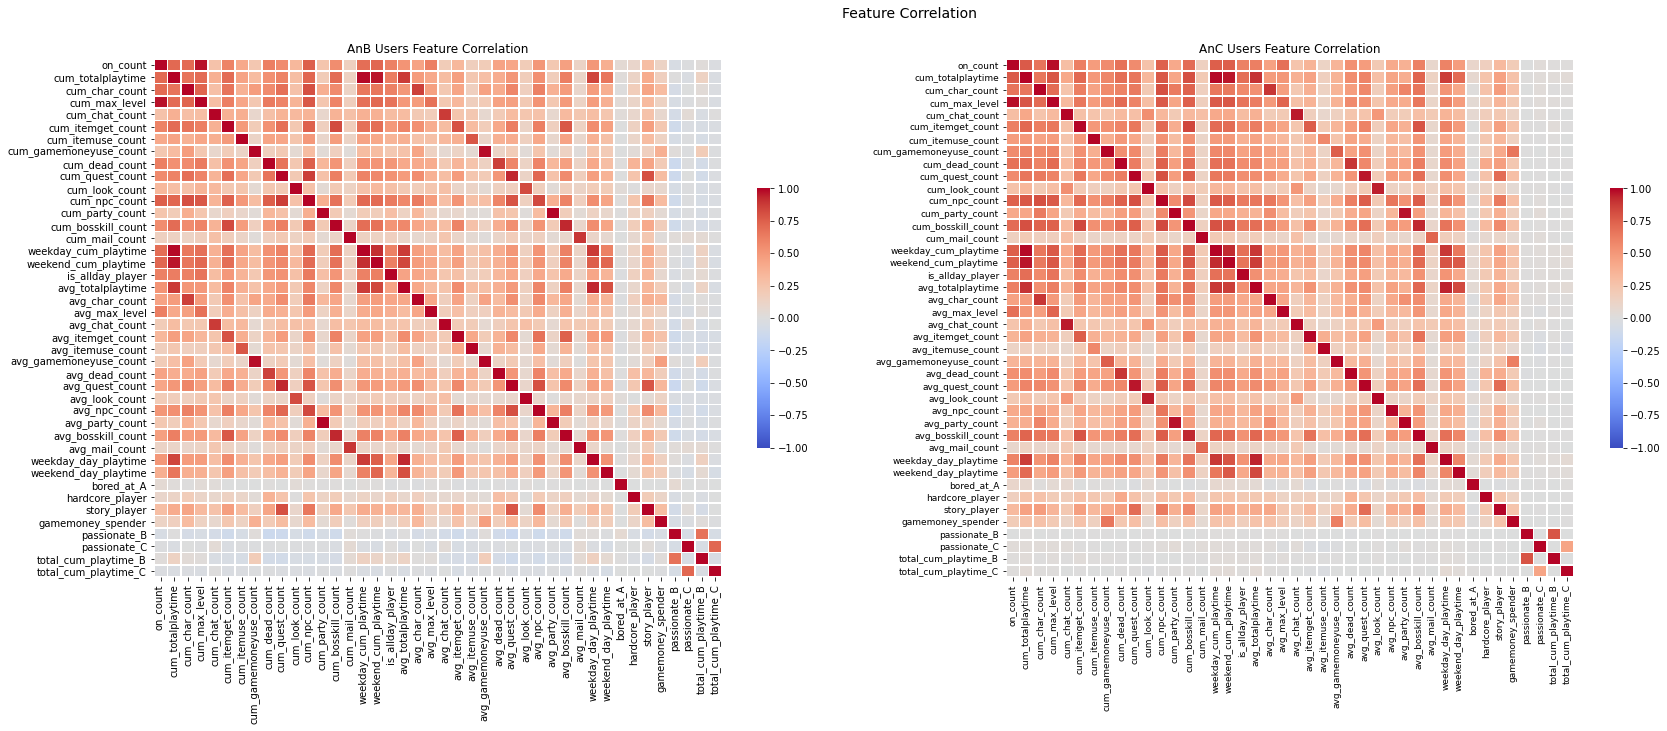

In [8]:
import seaborn as sns

plt.figure(figsize=(28, 9))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)

plt.subplot(1,2,1)
mask = np.triu(np.ones_like(A.loc[user_AnB,:].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnB,:].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("AnB Users Feature Correlation")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(1,2,2)
mask = np.triu(np.ones_like(A.loc[user_AnC,:].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnC,:].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.suptitle("Feature Correlation", fontsize=14)
plt.title("AnC Users Feature Correlation")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

# Step 2. Prediction
## 2-1. Predict label of 'Passionate player' : Classification

In [9]:
from sklearn.ensemble import RandomForestClassifier

def predict_IsPassionate(train, test, y_col):
    
    sc = StandardScaler()
    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)
    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)
    
    from imblearn.over_sampling import SMOTE 
    sm = SMOTE(random_state=42, k_neighbors=7)

    train_x, train_y = sm.fit_resample(train_x, train_y)
    
    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_x, train_y)
    pred_y = rf.predict(test_x)
    
    return pred_y

train_B = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1).copy()
test_B = A.drop(['total_cum_playtime_B'], axis=1).copy()
test_B = test_B.drop(user_AnB, axis=0)

pred_IsPassionate_B = predict_IsPassionate(train_B, test_B, "passionate_B")
A.loc[test_B.index, "passionate_B"] = pred_IsPassionate_B

train_C = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1).copy()
test_C = A.drop(['total_cum_playtime_C'], axis=1).copy()
test_C = test_C.drop(user_AnC, axis=0)

pred_IsPassionate_C = predict_IsPassionate(train_C, test_C, "passionate_C")
A.loc[test_C.index, "passionate_C"] = pred_IsPassionate_C

## Step 2-2. Predict probability of 'Passionate player' : Regression

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping

Epoch 1/1000
8/8 [==============================] - 3s 53ms/step - loss: 0.2958 - val_loss: 0.7239
Epoch 2/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.2294 - val_loss: 0.6237
Epoch 3/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2166 - val_loss: 0.5982
Epoch 4/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1968 - val_loss: 0.5591
Epoch 5/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2225 - val_loss: 0.5312
Epoch 6/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1968 - val_loss: 0.5269
Epoch 7/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1997 - val_loss: 0.5152
Epoch 8/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2108 - val_loss: 0.5179
Epoch 9/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.1995 - val_loss: 0.5011
Epoch 10/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2015 - val_loss: 0.5149
Epoch 11/1000
8/8

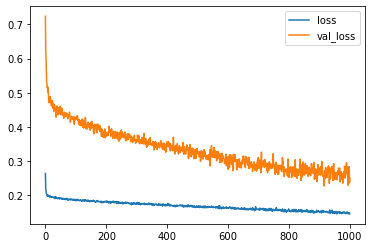

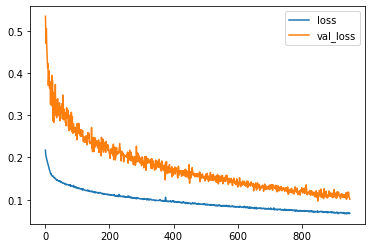

In [11]:
def predict_ProbPassionate(train, test, y_col):
    
    sc = StandardScaler()

    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)

    ## Oversampling for Class-imbalanced Problem
    from imblearn.over_sampling import SMOTE 
    sm = SMOTE(random_state=42, k_neighbors=7)
    sm_train_x, sm_train_y = sm.fit_resample(train_x, train_y)
    
    ## Model training with oversampled dataset
    N = sm_train_x.shape[0]
    M = sm_train_x.shape[1]
    sm_train_x = sm_train_x.reshape(N, M, 1).copy()
    
    model = Sequential()
    model.add(Conv1D(128, 8, input_shape=(M, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1))

    optimizer = SGD(0.01)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
    history = model.fit(x=np.array(sm_train_x),
                      y=np.array(sm_train_y),
                      validation_split = 0.3,
                      batch_size=128,
                      epochs=1000,
                      callbacks=[early_stop])

    losses = pd.DataFrame(history.history)
    losses.plot()
    
    ## Reload dataset (without smote) Fit and Predict Probability with original dataset
    N1 = train_x.shape[0]
    M1 = train_x.shape[1]
    train_x = train_x.reshape(N1, M1, 1).copy()

    N2 = test_x.shape[0]
    M2 = test_x.shape[1]
    test_x = test_x.reshape(N2, M2, 1).copy()

    prob_train = model.predict(train_x)
    prob_test = model.predict(test_x)
    
    ## Scale the prediction between 0 and 1
    msc = MinMaxScaler()
    prob_train = msc.fit_transform(prob_train)
    prob_test = msc.fit_transform(prob_test)
    
    prob_train = prob_train.reshape(len(train_x),)
    prob_test = prob_test.reshape(len(test_x),)
    
    return prob_train, prob_test

train_B = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1).copy()
test_B = A.drop(['total_cum_playtime_B'], axis=1).copy()
test_B = test_B.drop(user_AnB, axis=0)
pred_ProbPassionate_train_B,  pred_ProbPassionate_test_B = predict_ProbPassionate(train_B, test_B, "passionate_B")
A.loc[train_B.index, "prob_passionate_B"] = pred_ProbPassionate_train_B
A.loc[test_B.index, "prob_passionate_B"] = pred_ProbPassionate_test_B

train_C = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1).copy()
test_C = A.drop(['total_cum_playtime_C'], axis=1).copy()
test_C = test_C.drop(user_AnC, axis=0)
pred_ProbPassionate_train_C,  pred_ProbPassionate_test_C = predict_ProbPassionate(train_C, test_C, "passionate_C")
A.loc[train_C.index, "prob_passionate_C"] = pred_ProbPassionate_train_C
A.loc[test_C.index, "prob_passionate_C"] = pred_ProbPassionate_test_C


In [13]:
#A.to_csv(os.path.join(data_dir, 'final_A.csv'), header=True, index=True)

final_A = pd.read_csv(os.path.join(data_dir, 'final_A.csv'))
final_A.index = np.array(final_A[final_A.columns[0]])
final_A = final_A.drop([final_A.columns[0]], axis=1)

def reload_final_A():
    return final_A.replace(np.nan, 0).copy()

## 2-3. Predict 'cumulative play time' on other games: Regression

In [14]:
A = reload_final_A()

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import GradientBoostingRegressor

def predict_CumPlayTime(train, test, y_col):
    
    sc = StandardScaler()

    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)
    
    if y_col == 'total_cum_playtime_B':
        
        # Select model: Gradient Boositing Regressor
        gdb = GradientBoostingRegressor(random_state=0, n_estimators=500)
        gdb.fit(train_x, train_y)
        pred_train = gdb.predict(train_x)
        pred_test = gdb.predict(test_x)
        
    elif y_col == 'total_cum_playtime_C':
        
        N = train_x.shape[0]
        M = train_x.shape[1]
        train_x = train_x.reshape(N, M, 1).copy()

        N = test_x.shape[0]
        M = test_x.shape[1]
        test_x = test_x.reshape(N, M, 1).copy()
        
        # Select model: CNN
        model = Sequential()
        model.add(Conv1D(64, 8, input_shape=(M, 1)))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 8, input_shape=(M, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(1))
        optimizer = Adam(.0001)
        model.compile(optimizer=optimizer, loss='mse')

        early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
        history = model.fit(x=np.array(train_x),
                          y=np.array(train_y),
                          validation_split = 0.2,
                          batch_size=512,
                          epochs=1000,
                          callbacks=[early_stop])

        losses = pd.DataFrame(history.history)

        cnn = model
        pred_train = cnn.predict(train_x)
        pred_test = cnn.predict(test_x)
    
    # processing result value: remove minus time and remove maximum monthly available time
    pred_train = pred_train.reshape(len(train_x),)
    pred_test = pred_test.reshape(len(test_x),)
    
    pred_train[pred_train < 0] = 0
    pred_test[pred_test < 0] = 0

    pred_train[pred_train > (31*24*60)] = (31*24*60)
    pred_test[pred_test > (31*24*60)] = (31*24*60)
    
    return pred_train, pred_test
    
train_B = A.loc[user_AnB].copy()
test_B = A.drop(user_AnB, axis=0)
pred_CumPlayTime_train_B,  pred_CumPlayTime_test_B = predict_CumPlayTime(train_B, test_B, "total_cum_playtime_B")
A.loc[train_B.index, "pred_total_cum_playtime_B"] = pred_CumPlayTime_train_B
A.loc[test_B.index, "pred_total_cum_playtime_B"] = pred_CumPlayTime_test_B

train_C = A.loc[user_AnC].copy()
test_C = A.drop(user_AnC, axis=0)
pred_CumPlayTime_train_C,  pred_CumPlayTime_test_C = predict_CumPlayTime(train_C, test_C, "total_cum_playtime_C")
A.loc[train_C.index, "pred_total_cum_playtime_C"] = pred_CumPlayTime_train_C
A.loc[test_C.index, "pred_total_cum_playtime_C"] = pred_CumPlayTime_test_C

Epoch 1/1000
14/14 [==============================] - 1s 27ms/step - loss: 1629730.0333 - val_loss: 1145770.5000
Epoch 2/1000
14/14 [==============================] - 0s 10ms/step - loss: 1823035.8083 - val_loss: 1120469.1250
Epoch 3/1000
14/14 [==============================] - 0s 10ms/step - loss: 1618072.7500 - val_loss: 1066548.8750
Epoch 4/1000
14/14 [==============================] - 0s 10ms/step - loss: 1610641.2000 - val_loss: 1059607.3750
Epoch 5/1000
14/14 [==============================] - 0s 9ms/step - loss: 1341058.5583 - val_loss: 1048927.2500
Epoch 6/1000
14/14 [==============================] - 0s 10ms/step - loss: 1548536.4417 - val_loss: 1048007.3125
Epoch 7/1000
14/14 [==============================] - 0s 10ms/step - loss: 1484606.7500 - val_loss: 1043340.3750
Epoch 8/1000
14/14 [==============================] - 0s 9ms/step - loss: 1466806.7667 - val_loss: 1040210.5000
Epoch 9/1000
14/14 [==============================] - 0s 9ms/step - loss: 1580993.8000 - val_loss:

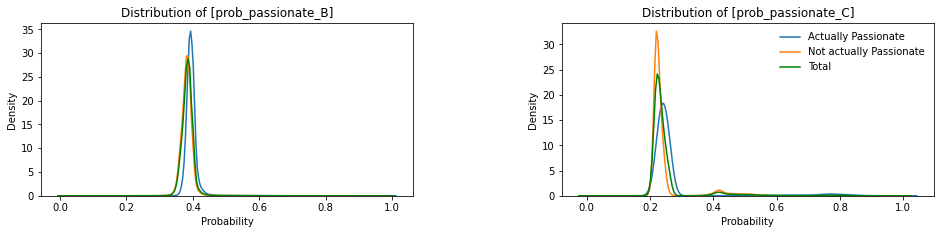

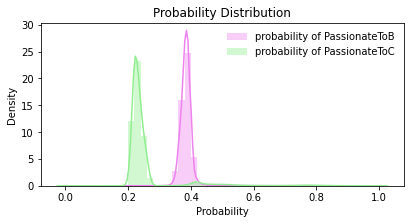

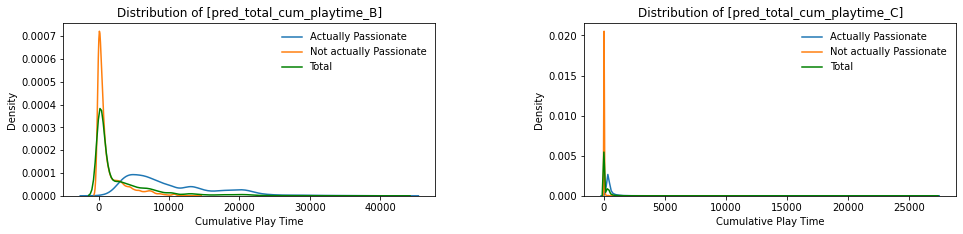

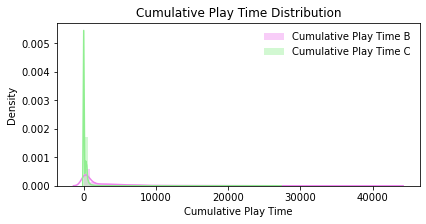

In [16]:
from scipy.stats import norm
import seaborn as sns

plt.figure(figsize=(16, 3))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(1,2,1)
sns.distplot(A[A['passionate_B'] == 1.0]['prob_passionate_B'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_B'] != 1.0]['prob_passionate_B'], label='Not actually Passionate', hist=False)
sns.distplot(A['prob_passionate_B'], label='Total', hist=False, color='green')
plt.title("Distribution of [prob_passionate_B]")
plt.xlabel("Probability")

plt.subplot(1,2,2)
sns.distplot(A[A['passionate_C'] == 1.0]['prob_passionate_C'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_C'] != 1.0]['prob_passionate_C'], label='Not actually Passionate', hist=False)
sns.distplot(A['prob_passionate_C'], label='Total', hist=False, color='green')
plt.title("Distribution of [prob_passionate_C]")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Probability")
plt.show()

plt.figure(figsize=(6.5, 3))
sns.distplot(A['prob_passionate_B'], label='probability of PassionateToB', color='violet')
sns.distplot(A['prob_passionate_C'], label='probability of PassionateToC', color='lightgreen')
plt.legend(frameon=False, loc='upper right')
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.show()


plt.figure(figsize=(16, 3))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(1,2,1)
sns.distplot(A[A['passionate_B'] == 1.0]['pred_total_cum_playtime_B'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_B'] != 1.0]['pred_total_cum_playtime_B'], label='Not actually Passionate', hist=False)
sns.distplot(A['pred_total_cum_playtime_B'], label='Total', hist=False, color='green')
plt.legend(frameon=False, loc='upper right')
plt.title("Distribution of [pred_total_cum_playtime_B]")
plt.xlabel("Cumulative Play Time")

plt.subplot(1,2,2)
sns.distplot(A[A['passionate_C'] == 1.0]['pred_total_cum_playtime_C'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_C'] != 1.0]['pred_total_cum_playtime_C'], label='Not actually Passionate', hist=False)
sns.distplot(A['pred_total_cum_playtime_C'], label='Total', hist=False, color='green')
plt.title("Distribution of [pred_total_cum_playtime_C]")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Cumulative Play Time")
plt.show()

plt.figure(figsize=(6.5, 3))
sns.distplot(A['pred_total_cum_playtime_B'], label='Cumulative Play Time B', color='violet')
sns.distplot(A['pred_total_cum_playtime_C'], label='Cumulative Play Time C', color='lightgreen')
plt.legend(frameon=False, loc='upper right')
plt.title("Cumulative Play Time Distribution")
plt.xlabel("Cumulative Play Time")
plt.show()

In [24]:
A.to_csv(os.path.join(data_dir, "result_df.csv"), header=True, index=False)

In [20]:
result = A[['pred_total_cum_playtime_B', 'prob_passionate_B', 'pred_total_cum_playtime_C', 'prob_passionate_C']]
output['A게임 유저ID'] = result.index
output.iloc[:,1:] = np.array(result.iloc[:,:])

In [22]:
output.to_csv(os.path.join(data_dir, "output_result.csv"), header=True, index=False)

# Evaluation with train data

In [25]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

print("Prediction for Probability of 'Passionate'")
train_B = A.loc[user_AnB].copy()
print("train data for game B -- MSE:\t\t", MSE(A.loc[train_B.index, "prob_passionate_B"], A.loc[train_B.index, "passionate_B"]).round(4))
print("train data for game B -- MAE:\t\t", MAE(A.loc[train_B.index, "prob_passionate_B"], A.loc[train_B.index, "passionate_B"]).round(4))
train_C = A.loc[user_AnC].copy()
print("train data for game C -- MSE:\t\t", MSE(A.loc[train_C.index, "prob_passionate_C"], A.loc[train_C.index, "passionate_C"]).round(4))
print("train data for game C -- MAE:\t\t", MAE(A.loc[train_C.index, "prob_passionate_C"], A.loc[train_C.index, "passionate_C"]).round(4))

print("\nPrediction for Cumulative Play Time")
train_B = A.loc[user_AnB].copy()
print("train data for game B -- MSE:\t\t", MSE(A.loc[train_B.index, "pred_total_cum_playtime_B"], A.loc[train_B.index, "total_cum_playtime_B"]).round(4))
print("train data for game B -- MAE:\t\t", MAE(A.loc[train_B.index, "pred_total_cum_playtime_B"], A.loc[train_B.index, "total_cum_playtime_B"]).round(4))
train_C = A.loc[user_AnC].copy()
print("train data for game C -- MSE:\t\t", MSE(A.loc[train_C.index, "pred_total_cum_playtime_B"], A.loc[train_C.index, "total_cum_playtime_B"]).round(4))
print("train data for game C -- MAE:\t\t", MAE(A.loc[train_C.index, "pred_total_cum_playtime_B"], A.loc[train_C.index, "total_cum_playtime_B"]).round(4))


Prediction for Probability of 'Passionate'
train data for game B -- MSE:		 0.1956
train data for game B -- MAE:		 0.4304
train data for game C -- MSE:		 0.176
train data for game C -- MAE:		 0.4074

Prediction for Cumulative Play Time
train data for game B -- MSE:		 110766.9326
train data for game B -- MAE:		 233.3529
train data for game C -- MSE:		 5747108.5172
train data for game C -- MAE:		 1329.0607
